Analyzing treesequence output from SLiM


In [2]:
import msprime, tskit, pyslim, time 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
orig_ts = tskit.load("../results/out.trees")

In [4]:
#Getting recombination information from slim simulation

#SLiM uses end positions while msprime uses start positions (msprime list will be n + 1)

Mut_rate = 1.5e-8
Rec_rate = 1e-8
#Amp_rec_rate = ??? SHOULD BE HIGHER

Chr_len = 9999
Sep_len = 2
Amplicon_len = 50
Sex_Chr_len = (Chr_len // 5) - Amplicon_len

'''   
SLiM code:

initializeRecombinationRate(c(Rec_rate, 0.5, Rec_rate, 0.5, 0, 0.5, 0, 0.5, 0, 0.5, 0, 0.5, 0),
		c(Chr_len, Chr_len + Sep_len,
		(Chr_len * 2) + Sep_len + 1,
		(Chr_len * 2) + (Sep_len * 2) + 1 + Amplicon_len,
		(Chr_len * 2) + (Sep_len * 2) + 2 + Amplicon_len + (Sex_Chr_len),
		(Chr_len * 2) + (Sep_len * 2) + 3 + (Amplicon_len * 2) + (Sex_Chr_len),
		(Chr_len * 2) + (Sep_len * 2) + 4 + (Amplicon_len * 2) + (Sex_Chr_len * 2),
		(Chr_len * 2) + (Sep_len * 2) + 5 + (Amplicon_len * 3) + (Sex_Chr_len * 2),
		(Chr_len * 2) + (Sep_len * 2) + 6 + (Amplicon_len * 3) + (Sex_Chr_len * 3),
		(Chr_len * 2) + (Sep_len * 2) + 7 + (Amplicon_len * 4) + (Sex_Chr_len * 3),
		(Chr_len * 2) + (Sep_len * 2) + 8 + (Amplicon_len * 4) + (Sex_Chr_len * 4),
		(Chr_len * 2) + (Sep_len * 2) + 9 + (Amplicon_len * 5) + (Sex_Chr_len * 4),
		(Chr_len * 2) + (Sep_len * 2) + 10 + (Amplicon_len * 5) + (Sex_Chr_len * 5)), sex="M");
        
        
initializeRecombinationRate(c(Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate),
		c(Chr_len, Chr_len + Sep_len,
		(Chr_len * 2) + Sep_len + 1,
		(Chr_len * 2) + (Sep_len * 2) + 1,
		(Chr_len * 2) + (Sep_len * 2) + 2 + Amplicon_len + (Sex_Chr_len),
		(Chr_len * 2) + (Sep_len * 2) + 3 + (Amplicon_len * 2) + (Sex_Chr_len),
		(Chr_len * 2) + (Sep_len * 2) + 4 + (Amplicon_len * 2) + (Sex_Chr_len * 2),
		(Chr_len * 2) + (Sep_len * 2) + 5 + (Amplicon_len * 3) + (Sex_Chr_len * 2),
		(Chr_len * 2) + (Sep_len * 2) + 6 + (Amplicon_len * 3) + (Sex_Chr_len * 3),
		(Chr_len * 2) + (Sep_len * 2) + 7 + (Amplicon_len * 4) + (Sex_Chr_len * 3),
		(Chr_len * 2) + (Sep_len * 2) + 8 + (Amplicon_len * 4) + (Sex_Chr_len * 4),
		(Chr_len * 2) + (Sep_len * 2) + 9 + (Amplicon_len * 5) + (Sex_Chr_len * 4),
		(Chr_len * 2) + (Sep_len * 2) + 10 + (Amplicon_len * 5) + (Sex_Chr_len * 5)), sex="F");
}

'''
Positions = [Chr_len, Chr_len + Sep_len,
		(Chr_len * 2) + Sep_len + 1,
		(Chr_len * 2) + (Sep_len * 2) + 1,
		(Chr_len * 2) + (Sep_len * 2) + 2 + Amplicon_len + (Sex_Chr_len),
		(Chr_len * 2) + (Sep_len * 2) + 3 + (Amplicon_len * 2) + (Sex_Chr_len),
		(Chr_len * 2) + (Sep_len * 2) + 4 + (Amplicon_len * 2) + (Sex_Chr_len * 2),
		(Chr_len * 2) + (Sep_len * 2) + 5 + (Amplicon_len * 3) + (Sex_Chr_len * 2),
		(Chr_len * 2) + (Sep_len * 2) + 6 + (Amplicon_len * 3) + (Sex_Chr_len * 3),
		(Chr_len * 2) + (Sep_len * 2) + 7 + (Amplicon_len * 4) + (Sex_Chr_len * 3),
		(Chr_len * 2) + (Sep_len * 2) + 8 + (Amplicon_len * 4) + (Sex_Chr_len * 4),
		(Chr_len * 2) + (Sep_len * 2) + 9 + (Amplicon_len * 5) + (Sex_Chr_len * 4),
		(Chr_len * 2) + (Sep_len * 2) + 10 + (Amplicon_len * 5) + (Sex_Chr_len * 5)]

#No rec in males outside PAR
Male_Recrates = [Rec_rate, 0.5, Rec_rate, 0.5, 0, 0.5, 0, 0.5, 0, 0.5, 0, 0.5, 0]
Female_recrates = [Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate] 

#Recombination maps in tsv files use cM/Mb as a standard
#Rescaling recombination rates accordingly:
Male_Recrates_scaled = [r / 1e-8 for r in Male_Recrates]
Female_Recrates_scaled = [r / 1e-8 for r in Female_recrates]

Female_Recrates_scaled


[1.0,
 50000000.0,
 1.0,
 50000000.0,
 1.0,
 50000000.0,
 1.0,
 50000000.0,
 1.0,
 50000000.0,
 1.0,
 50000000.0,
 1.0]

In [9]:
#Writing recombination rates in tsv file 
column_names = ["end_position", "rate(cM/Mb)"]

data = {"end_position" : Positions, "rate(cM/Mb)" : Female_Recrates_scaled}
df = pd.DataFrame(data)

df.to_csv(("../data/Female_recomb_rates.tsv"), sep='\t', index=False, header=column_names)

In [12]:
#Recapitation with a nonuniform recombination map
#WE HAVE 2 DIFFERENT MAPS FOR SEXES THIS NEEDS SOME OTHER CODE TO MAKE FEMALE/MALE NODES WITH DIFFERENT RECOMB MAPS <=== DAVIDE

positions = []
rates = []
with open('../data/Female_recomb_rates.tsv', 'r') as file:
  header = file.readline().strip().split("\t")
  assert(header[0] == "end_position" and header[1] == "rate(cM/Mb)")
  for line in file:
     components = line.split("\t")
     positions.append(float(components[0]))
     rates.append(1e-8 * float(components[1]))

# step 1
positions.insert(0, 0)
# step 2
positions[-1] += 1
assert positions[-1] == orig_ts.sequence_length

recomb_map = msprime.RateMap(position=positions, rate=rates)
rts = pyslim.recapitate(orig_ts,
                recombination_rate=recomb_map,
                ancestral_Ne=100)
assert(max([t.num_roots for t in rts.trees()]) == 1)

In [ ]:
rts

In [24]:
orig_ts = tskit.load("../results/out.trees")

In [5]:
#Simplification: discarding less informing nodes from tree
#Here this is done without recapitation, directly from output file orig_ts.

import numpy as np
rng = np.random.default_rng(seed=3)
alive_inds = pyslim.individuals_alive_at(orig_ts, 0)
keep_indivs = rng.choice(alive_inds, 100, replace=False)
keep_nodes = []
for i in keep_indivs:
  keep_nodes.extend(orig_ts.individual(i).nodes)

#sts = rts.simplify(keep_nodes, keep_input_roots=True) #WITH RECAPITATION %%%All other orig_ts => rts
sts = orig_ts.simplify(keep_nodes, keep_input_roots=True) #WITHOUT RECAPITATION


print(f"Before, there were {orig_ts.num_samples} sample nodes (and {orig_ts.num_individuals} individuals)\n"
      f"in the tree sequence, and now there are {sts.num_samples} sample nodes\n"
      f"(and {sts.num_individuals} individuals).")

Before, there were 214 sample nodes (and 107 individuals)
in the tree sequence, and now there are 200 sample nodes
(and 105 individuals).


In [6]:
#Adding neutral mutation types after the simulation has occured
#ACTUALLY WE HAVE ONLY NEUTRAL MUTATION TYPES IN OUR SIMULATION <====== DAVIDE
next_id = pyslim.next_slim_mutation_id(sts)
ts = msprime.sim_mutations(
           sts,
           rate=Mut_rate,
           model=msprime.SLiMMutationModel(type=0, next_id=next_id), #using mutation type 0 because its not used in SLiM 
           keep=True, #keeps other mut types 
)

print(f"The tree sequence now has {ts.num_mutations} mutations,\n"
      f"and mean pairwise nucleotide diversity is {ts.diversity():0.3e}.")

The tree sequence now has 181 mutations,
and mean pairwise nucleotide diversity is 3.663e-04.


In [7]:
ts

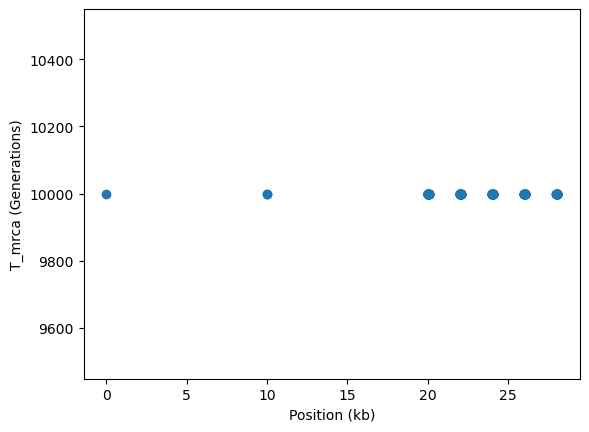

In [36]:
#Calculating TMRCA for given tree sequence (Only one root)

#counting how many trees has more than one branch 
trees_onebranch = [tree for tree in ts.trees() if len(tree.roots) == 1]

tmrca = np.zeros(len(trees_onebranch)) #initializing lists
breakpoints = np.zeros(len(trees_onebranch))
for tree in ts.trees():
    if len(tree.roots) == 1:
        tmrca[tree.index] = tree.time(tree.root)
        breakpoints[tree.index] = tree.interval[0]
plt.ylabel("T_mrca (Generations)")
plt.xlabel("Position (kb)")
plt.plot(breakpoints / 1000, tmrca, "o")